In [43]:
import pandas as pd
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
from qtl.annotation import Annotation

sys.path.append("../funcs")

import smm_utils as smm
import plot as pl

---
# Analysis of SMM Transcriptomes pt. 1

This notebook contains code to process RNA, examine QC metrics, and look at overlap with known Myeloma signature genes at our dataset. This analysis is continued in a second `R` notebook.

**Author**: [Shankara Anand](sanand@broadinstitute.org)

In [55]:
JAN_METRICS = '../data/rna/Janssen_RNA.metrics.tsv'
JAN_TPMS = '../data/rna/Janssen_RNA.rnaseqc_tpm.gct.gz'
JAN_COUNTS = '../data/rna/Janssen_RNA.rnaseqc_counts.gct.gz'
JAN_CLINICAL = '../data/rna/Janssen_clinical_meta.txt'
RNA_GTF = "../data/rna/gencode.v19.genes.v7.patched_contigs.gtf"

In [20]:
PLOT_DIR = "figures"
os.makedirs(PLOT_DIR, exist_ok=True)

SUPP_DIR = "supplement"
os.makedirs(SUPP_DIR, exist_ok=True)

---

## 1. Load RNASeQC Metrics

* We use a cutoff of `0.8` for median exon CV to filter out poor quality RNA samples

In [7]:
MEDIAN_EXON_CV_CUTOFF = 0.8

In [8]:
metrics = pd.read_csv(JAN_METRICS,sep='\t')
metrics['Sample'] = [x.lower() for x in metrics['Sample']]
metrics['filter'] = metrics['Median Exon CV'] < MEDIAN_EXON_CV_CUTOFF

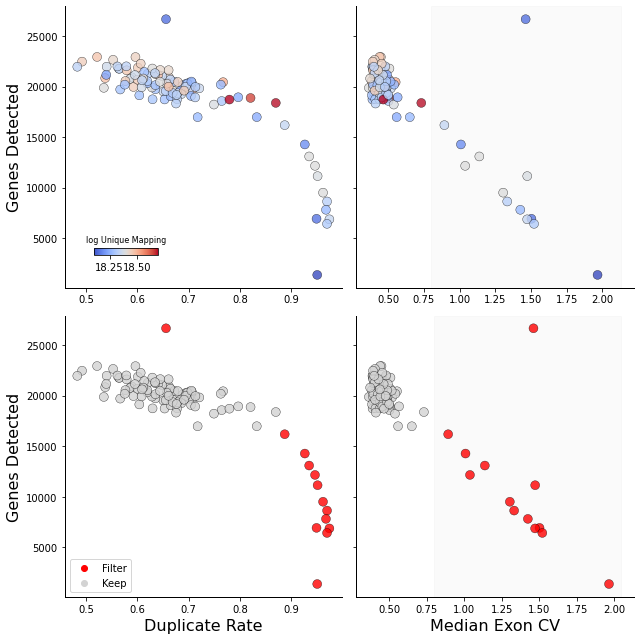

In [32]:
pl.plot_rnaseqc_metrics_grid(metrics, MEDIAN_EXON_CV_CUTOFF)
plt.savefig(os.path.join(PLOT_DIR, "figS3_rnaseqc_metrics.pdf"), dpi=300, bbox_inches='tight')

---

## 2. Load RNASeQC Counts / TPM

* Filter for detected genes & normalize TPM
* Inspect PCA w/ metrics & clinical data
* Parse GTF for biotype & save processed counts/tpms

In [36]:
tpm, tpm_norm, counts, gene_name = smm.tpm_loader(
    JAN_TPMS,
    JAN_COUNTS,
    samples=metrics['Sample'][metrics['filter']].apply(lambda x: x.capitalize()).values
)

tpm.columns = [x.lower() for x in tpm.columns]
tpm_norm.columns = [x.lower() for x in tpm_norm.columns]
counts.columns = [x.lower() for x in counts.columns]

In [40]:
P_df,pca = smm.get_pcs(tpm)

In [44]:
corr_df = P_df.join(metrics.set_index('Sample')).corr('pearson')
corr_df = corr_df.loc[P_df.columns, set(corr_df)-set(P_df.columns)]
pca_corrs = ((corr_df.T.dropna() ** 2).sort_values(0,ascending=False) ** 0.5).rename(columns={x:'PC'+str(x) for x in list(P_df.columns)})
pca_corrs.to_csv(os.path.join(SUPP_DIR, "table8_metrics_to_pcs.tsv"), sep='\t')
pca_corrs.head()

,PC0,PC1,PC2,PC3,PC4
3' bias Std,0.645874,0.183715,0.236861,0.168255,0.019994
Avg. Splits per Read,0.583402,0.203699,0.226103,0.267233,0.142468
Exonic Rate,0.581944,0.069691,0.100419,0.154403,0.127655
High Quality Intronic Rate,0.576194,0.010145,0.114084,0.150471,0.090601
Expression Profiling Efficiency,0.572663,0.011853,0.024356,0.143390,0.164698


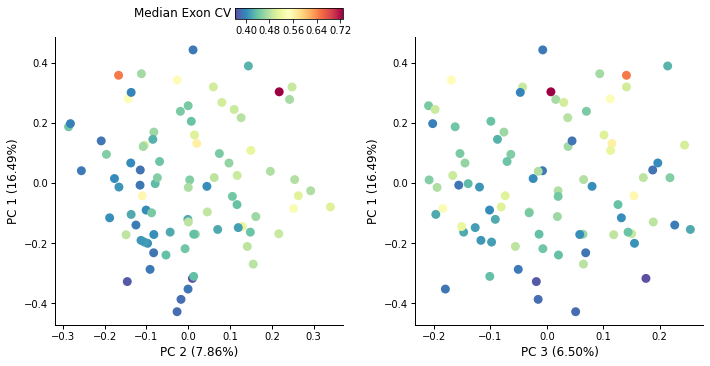

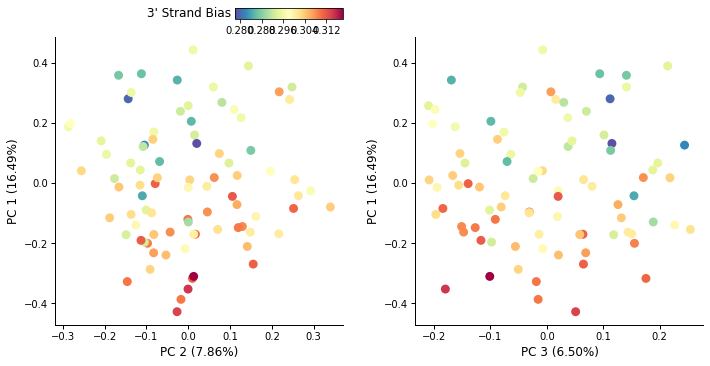

In [45]:
_ = smm.plot_pca(
    P_df, 
    pca, 
    c=metrics[metrics['Sample'].isin(list(tpm))]["Median Exon CV"],
    s=80,
    clabel='Median Exon CV'
)
_ = smm.plot_pca(
    P_df, 
    pca, 
    c=metrics[metrics['Sample'].isin(list(tpm))]["3' bias Std"],
    s=80,
    clabel="3' Strand Bias"
)

In [51]:
clinical_meta_df = pd.read_csv(JAN_CLINICAL, sep='\t', index_col=0)
corr_df = P_df.join(clinical_meta_df).corr('pearson')
corr_df = corr_df.loc[P_df.columns, set(corr_df)-set(P_df.columns)]
pca_corrs = ((corr_df.T.dropna() ** 2).sort_values(0,ascending=False) ** 0.5).rename(columns={x:'PC'+str(x) for x in list(P_df.columns)})
pca_corrs.to_csv(os.path.join(SUPP_DIR, "table8_clinical_meta_to_pcs.tsv"), sep='\t')
pca_corrs.head()

,PC0,PC1,PC2,PC3,PC4
BM%,0.439106,0.259204,0.041164,0.123691,0.115418
IgM (mg/dL),0.365880,0.092764,0.056019,0.287079,0.121407
M protein (g/dL),0.356667,0.224168,0.130506,0.183251,0.335037
TP (g/dL),0.324071,0.210750,0.181242,0.197580,0.353576
Hgb (g/dL),0.283452,0.115089,0.015394,0.066660,0.120937


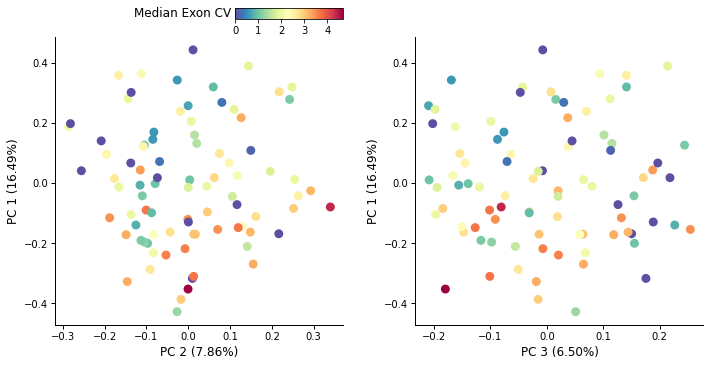

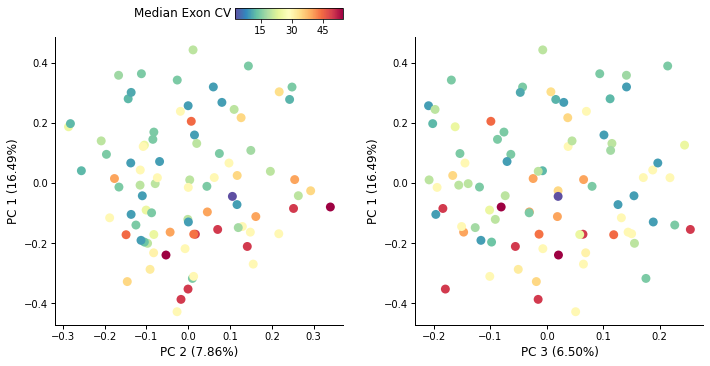

In [52]:
_ = smm.plot_pca(
    P_df, 
    pca, 
    c=clinical_meta_df.loc[P_df.index]['M protein (g/dL)'],
    s=80,
    clabel='Median Exon CV'
)
_ = smm.plot_pca(
    P_df, 
    pca, 
    c=clinical_meta_df.loc[P_df.index]['BM%'],
    s=80,
    clabel='Median Exon CV'
)

In [53]:
# Save Filtered TPM, Normalized TPM, Counts
tpm.to_csv(os.path.join(SUPP_DIR, "table9a_janssen_tpm.tsv"),sep='\t')
tpm_norm.to_csv(os.path.join(SUPP_DIR, "table9b_janssen_tpm_norm.tsv"),sep='\t')
counts[tpm.columns].to_csv(os.path.join(SUPP_DIR, "table9c_janssen_counts.tsv"),sep='\t')

# Save Gene Name w/ Biotype
annot = Annotation(RNA_GTF)
gene_name['biotype'] = [annot.get_gene(x).biotype for x in gene_name.index]
gene_name.to_csv(os.path.join(SUPP_DIR, "table9d_gene_name.tsv"),sep='\t')

---

## 3. Myeloma Signatures

* Pulled up/down regulated genes per myeloma signature outlined in Zhan et al & Sonnevald et al to `../data/ref/`
* Inspected mean expression across genes per cluster
* Saved gene-sets for fGSEA analysis

In [12]:
SONN_UP = '../data/ref/sonneveld_upreg_sigs.txt'
SONN_DOWN = '../data/ref/sonneveld_downreg_sigs.txt'
ZHAN_UP = '../data/ref/zhan_upreg_sigs.txt'
ZHAN_DOWN = '../data/ref/zhan_downreg_sigs.txt'

In [8]:
# Metadata w/ Clusters
meta_df = pd.read_csv("../Fig1/supplement/table4_sample_cluster_id.tsv",sep='\t',index_col=0)

# Norm TPM
tpm_df = pd.read_csv("supplement/table9b_janssen_tpm_norm.tsv",sep='\t',index_col=0)
tpm_df.columns = [x.lower() for x in tpm_df.columns]

# Intersecting Samples
i_samples = np.intersect1d(tpm_df.columns, meta_df.index)
tpm_df = tpm_df.loc[:,i_samples]
meta_df = meta_df.loc[i_samples]

# Gene ID name
gene_df = pd.read_csv("supplement/table9d_gene_name.tsv",sep='\t',index_col=0)

In [23]:
def get_mean_genes_expr(gene_set, how='mean', subtype=''):
    """
    Plot mean genes.
    """
    i_genes = np.intersect1d(gene_set, tpm_df.index)
    print("   {} * {}/{} genes detected".format(subtype, i_genes.shape[0], len(gene_set)))
    _tpm_df = tpm_df.loc[i_genes]
    
    if how=='mean':
        return pd.DataFrame(_tpm_df.mean(0), columns=['index'])
    elif how=='sum':
        return pd.DataFrame(_tpm_df.sum(0), columns=['index'])

def get_mean_subtype_expr(sigs_df, subtype, **kwargs):
    """
    Get mean subtype expression.
    """
    gene_ids = sigs_df[sigs_df['subtype']==subtype].dropna()['Name']
    return get_mean_genes_expr(gene_ids, subtype=subtype,**kwargs)

def build_mean_subtype_set(sigs_df):
    """
    Build full set.
    """
    signature_profiles = pd.unique(sigs_df['subtype'])
    
    df = pd.concat([get_mean_subtype_expr(sigs_df,x) for x in signature_profiles],1)
    df.columns = signature_profiles
    return df.join(meta_df['consensus_nmf'])

In [15]:
# Load Zhan + Sonnevald Signatures
zhan_df = pd.concat([pd.read_csv(ZHAN_UP,sep='\t'),pd.read_csv(ZHAN_DOWN,sep='\t')]).rename(columns={'Gene':'gene_symbol','Subgroup':'subtype','SAM_score':'score'})
zhan_df['src'] = 'zhan'

sonn_up_df = pd.read_csv(SONN_UP,sep='\t')
sonn_down_df = pd.read_csv(SONN_DOWN,sep='\t')
sonn_down_df['fold_change'] = sonn_down_df['fold_change']*-1
sonn_df = pd.concat([sonn_up_df,sonn_down_df]).rename(columns={'fold_change':'score'})
sonn_df['src'] = 'sonnevald'

def _f(x):
    if x=='HY':
        return "HP"
    else:
        return x
    
sonn_df['subtype'] = sonn_df['subtype'].apply(_f)

sigs_df = pd.concat((zhan_df,sonn_df))[['gene_symbol','score','subtype','src']]
sigs_df = sigs_df[~sigs_df['gene_symbol'].isna()]
sigs_df['gene_symbol'] = sigs_df['gene_symbol'].apply(lambda x: x.split(' /// '))
sigs_df = sigs_df.explode('gene_symbol')

# Load Gene-ID Mappings
gene_df = gene_df[gene_df.Description.isin(sigs_df['gene_symbol'].unique())]
gene_df = gene_df.drop(index='ENSGR0000002586.13').reset_index()

# Merge Gene-Names
sigs_df = pd.merge(sigs_df,  gene_df, how='left', left_on='gene_symbol',  right_on='Description')
sigs_df.to_csv("../data/ref/myeloma_mapped_signatures.tsv",sep='\t')

In [24]:
print("Zhan:")
build_mean_subtype_set(sigs_df[(sigs_df['src']=='zhan') & (sigs_df['score']>0)]).to_csv(os.path.join(SUPP_DIR, "table10a_zhan_mean_sigs.tsv"), sep='\t')
print("Sonnevald:")
build_mean_subtype_set(sigs_df[(sigs_df['src']=='sonnevald') & (sigs_df['score']>0)]).to_csv(os.path.join(SUPP_DIR, "table10b_sonn_mean_sigs.tsv"), sep='\t')
print("Both:")
build_mean_subtype_set(sigs_df[sigs_df['score']>0]).to_csv(os.path.join(SUPP_DIR, "table10c_combined_mean_sigs.tsv"), sep='\t')

Zhan:
   PR * 28/32 genes detected
   LB * 33/33 genes detected
   MS * 35/36 genes detected
   HP * 37/37 genes detected
   CD-1 * 35/37 genes detected
   CD-2 * 34/34 genes detected
   MF * 32/33 genes detected
Sonnevald:
   CD-2 * 33/43 genes detected
   CD-1 * 36/40 genes detected
   CTA * 35/43 genes detected
   NFkB * 32/38 genes detected
   HP * 42/46 genes detected
   PRL3 * 16/17 genes detected
   PR * 37/51 genes detected
   MS * 41/50 genes detected
   MF * 40/46 genes detected
   LB * 19/20 genes detected
Both:
   PR * 56/83 genes detected
   LB * 49/53 genes detected
   MS * 68/86 genes detected
   HP * 71/83 genes detected
   CD-1 * 64/77 genes detected
   CD-2 * 59/77 genes detected
   MF * 65/79 genes detected
   CTA * 35/43 genes detected
   NFkB * 32/38 genes detected
   PRL3 * 16/17 genes detected


In [29]:
def create_GMT_from_dataframe(
    df, 
    outfile, 
    tag='MYELOMA_SIG_', 
    gene_idx='gene_symbol', 
    subtype_idx='subtype',
    split_up_down=True
    ):
    """
    Create GMT from dataframe.
    ----------------------------
    Script to convert gene-sets to GMT files for pathway analysis.
    """
    sigs_df = df.dropna()
    
    with open(outfile, 'w') as f:
        if split_up_down:
            _sigs_df = sigs_df[sigs_df['score']>0]
            for subtype in pd.unique(_sigs_df[subtype_idx]):
                line_out = "{}{}_UP\t{}\t".format(tag,subtype,"custom")
                line_out += '\t'.join(_sigs_df[_sigs_df[subtype_idx]==subtype][gene_idx].values)
                f.write(line_out+'\n')
                
            _sigs_df = sigs_df[sigs_df['score']<0]
            for subtype in pd.unique(_sigs_df[subtype_idx]):
                line_out = "{}{}_DOWN\t{}\t".format(tag,subtype,"custom")
                line_out += '\t'.join(_sigs_df[_sigs_df[subtype_idx]==subtype][gene_idx].values)
                f.write(line_out+'\n')
                
        else:
            for subtype in pd.unique(sigs_df[subtype_idx]):
                line_out = "{}\t{}\t".format(subtype,"custom")
                line_out += '\t'.join(sigs_df[sigs_df[subtype_idx]==subtype][gene_idx].values)
                f.write(line_out+'\n')
                
    print("   * saving to {}".format(outfile))

In [129]:
create_GMT_from_dataframe(sigs_df, '../data/ref/gmts/mm_sigs_custom.gmt.txt')

   * saving to data/ref/gmts/mm_sigs_custom.gmt.txt


#### Signatures from Staudt 2020

In [30]:
sigdb_df = pd.read_csv("../data/ref/SignatureDB_030920.txt", sep='\t', encoding='latin-1')
sigdb_df.columns = sigdb_df.columns.str.replace("____","")

In [152]:
create_GMT_from_dataframe(
    sigdb_df, 
    '../data/ref/gmts/staudt_2020.gmt.txt', 
    gene_idx='Gene symbol concensus', 
    subtype_idx='Signature',
    split_up_down=False
)

   * saving to data/ref/gmts/staudt_2020.gmt.txt


In [42]:
# Combine with Pathway Enrichment
sigdb_e_df = pd.read_csv("supplement/table11b_enrich_staudt.tsv", sep='\t')
pd.merge(sigdb_e_df, sigdb_df[['Signature','Signature category','Signature subcategory']].drop_duplicates(),  left_on='pathway', right_on='Signature', how='left').to_csv("supplement/table11b_enrich_staudt.tsv",sep='\t')

In [45]:
# Combine with Pathway Enrichment
sigdb_e_df = pd.read_csv("supplement/table11e_enrich_staudt_v2.tsv", sep='\t')
pd.merge(sigdb_e_df, sigdb_df[['Signature','Signature category','Signature subcategory']].drop_duplicates(),  left_on='pathway', right_on='Signature', how='left').to_csv("supplement/table11e_enrich_staudt_v2.tsv",sep='\t')